<h4>1 - Install the required libraries</h4>
~<code>pip install flask flask_cors pandas seaborn sklearn openpyxl</code>

In [13]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
import pickle

<h4>2 - Read Training Data</h4>

In [14]:
train_data = pd.read_excel('Flight-Dataset/Data_Train.xlsx')
train_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


<h4>3 - Checking values in the Destination column</h4>
This shows that the maximum people are going to Cochin followed by Banglore and then Delhi in the dataset.

In [15]:
train_data['Destination'].value_counts()

Cochin       4537
Banglore     2871
Delhi        1265
New Delhi     932
Hyderabad     697
Kolkata       381
Name: Destination, dtype: int64

Merging Delhi and New Delhi.

In [16]:
def newd(x):
    if x=='New Delhi':
        return 'Delhi'
    else:
        return x
train_data['Destination'] = train_data['Destination'].apply(newd)

<h4>4 - Data preprocessing</h4>
<ul>
  <li>Drop <code>Route</code> and <code>Additional_Info</code> columns.</li>
  <li>We extract the journey day and journey month from the <code>Date_of_Journey</code> and create new columns <code>Journey_day</code> and <code>Journey_month</code>. We drop <code>Date_of_Journey</code> column.</li>
  <li>We extract the departure hour and departure min from the <code>Dep_Time</code> and create new columns <code>Dep_hour</code> and <code>Dep_min</code>. We drop <code>Dep_Time</code> column.</li>
  <li>We extract the arrival hour and arrival min from the <code>Arrival_Time</code> and create new columns <code>Arrival_hour</code> and <code>Arrival_min</code>. We drop <code>Arrival_Time</code> column.</li>
  <li>We extract the duration hour and duration min from the <code>Duration</code> and create new columns <code>Duration_hours</code> and <code>Duration_mins</code>. We drop <code>Duration</code> column.</li>
</ul>

In [17]:
# Route and Additional_Info
train_data.drop(['Route','Additional_Info'], inplace=True, axis=1)

# Journey Date
train_data['Journey_day'] = pd.to_datetime(train_data['Date_of_Journey'], format='%d/%m/%Y').dt.day
train_data['Journey_month'] = pd.to_datetime(train_data['Date_of_Journey'], format='%d/%m/%Y').dt.month
train_data.drop('Date_of_Journey', inplace=True, axis=1)

# Departure Time
train_data['Dep_hour'] = pd.to_datetime(train_data['Dep_Time']).dt.hour
train_data['Dep_min'] = pd.to_datetime(train_data['Dep_Time']).dt.minute
train_data.drop('Dep_Time', axis=1, inplace=True)

# Arrival Time
train_data['Arrival_hour'] = pd.to_datetime(train_data['Arrival_Time']).dt.hour
train_data['Arrival_min'] = pd.to_datetime(train_data['Arrival_Time']).dt.minute
train_data.drop('Arrival_Time', axis=1,inplace=True)

# Duration
duration = list(train_data['Duration'])
for i in range(len(duration)):
    if len(duration[i].split()) != 2:
        if 'h' in duration[i]:
            duration[i] = duration[i] + ' 0m'
        else:
            duration[i] = '0h ' + duration[i]
duration_hour = []
duration_min = []
for i in duration:
    h,m = i.split()
    duration_hour.append(int(h[:-1]))
    duration_min.append(int(m[:-1]))
train_data['Duration_hours'] = duration_hour
train_data['Duration_mins'] = duration_min
train_data.drop('Duration',axis=1,inplace=True)

train_data.head()

,Airline,Source,Destination,Total_Stops,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins
0,IndiGo,Banglore,Delhi,non-stop,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,2 stops,7662,1,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,2 stops,13882,9,6,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,1 stop,6218,12,5,18,5,23,30,5,25
4,IndiGo,Banglore,Delhi,1 stop,13302,1,3,16,50,21,35,4,45


<h4>5 - Plotting Airline vs Price.</h4>
It seems Jet Airways business is the costliest airways.

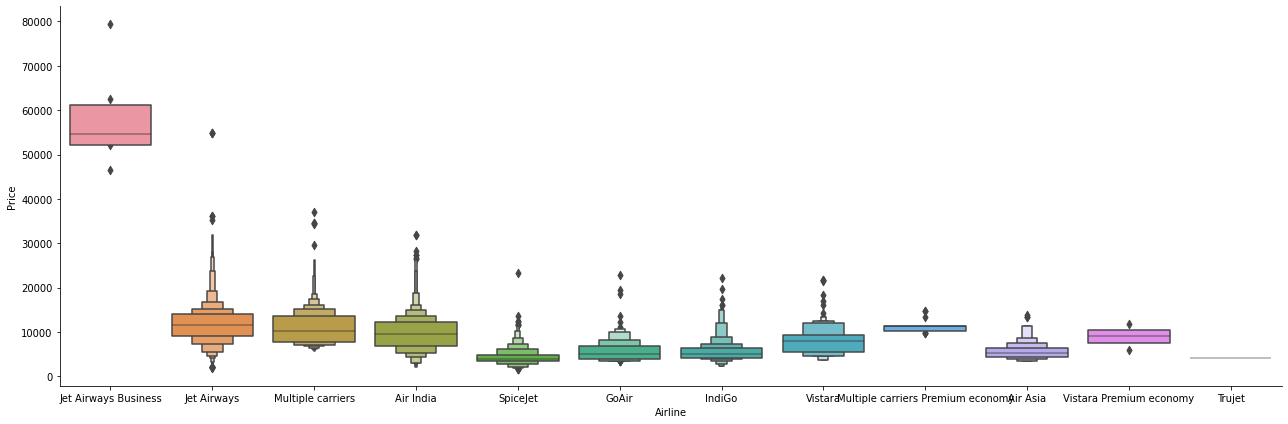

In [18]:
sns.catplot(
  x='Airline',
  y='Price',
  data=train_data.sort_values('Price',ascending=False),
  kind='boxen',
  aspect=3,
  height=6
  )

<h4>6 - Plotting Source vs Price</h4>
It seems if your source is Bangalore, no matter where you're going you have to pay the highest amount of money.

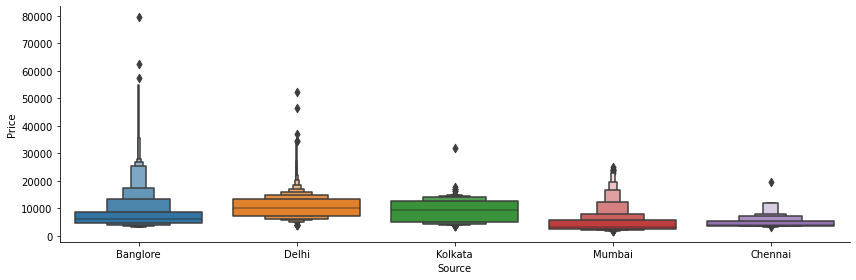

In [19]:
# If we are going from Banglore the prices are slightly higher as compared to other cities
sns.catplot(
  x='Source',
  y='Price',
  data=train_data.sort_values('Price',ascending=False),
  kind='boxen',
  aspect=3,
  height=4
  )

<h4>7 - Plotting Destination vs Price.</h4>
It seems no matter the source, if your destination is New Dehli, you have to pay the highet amount of money.

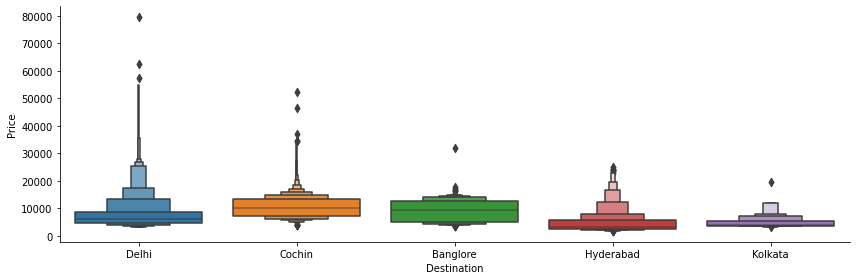

In [20]:
sns.catplot(
  x='Destination',
  y='Price',
  data=train_data.sort_values('Price',
  ascending=False),
  kind='boxen',
  aspect=3,
  height=4
  )

<h4>8 - Create dummy columns out of the <code>Airline</code>, <code>Source</code> and <code>Destination</code> columns.</h4>

In [21]:
airline = train_data[['Airline']]
airline = pd.get_dummies(airline,drop_first=True)

source = train_data[['Source']]
source = pd.get_dummies(source,drop_first=True)

destination = train_data[['Destination']]
destination = pd.get_dummies(destination,drop_first=True)

In [22]:
source.head()

,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai
0,0,0,0,0
1,0,0,1,0
2,0,1,0,0
3,0,0,1,0
4,0,0,0,0


In [23]:
destination.head()

,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata
0,0,1,0,0
1,0,0,0,0
2,1,0,0,0
3,0,0,0,0
4,0,1,0,0


<h4>9 - Converting labels into numbers in the Total_stops column.</h4>
According to the data, price is directly proportional to the number of stops.

In [24]:
totalStopDictConv = {
  'non-stop': int(0),
  '1 stop': int(1),
  '2 stops': int(2),
  '3 stops': int(3),
  '4 stops': int(4)
}

# Total Stops
train_data['Total_Stops'].replace(totalStopDictConv, inplace=True)
train_data.head()

,Airline,Source,Destination,Total_Stops,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins
0,IndiGo,Banglore,Delhi,0.0,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,2.0,7662,1,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,2.0,13882,9,6,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,1.0,6218,12,5,18,5,23,30,5,25
4,IndiGo,Banglore,Delhi,1.0,13302,1,3,16,50,21,35,4,45
